## 3 Stage Hierarchical Bayesian Change Point Model
- General model can be applied to any time series with counts

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Bayesian Stochastic Modelling Library
import pymc3 as pm

# To pickle trace
import pickle

Let $Y_1, Y_2, ..., Y_n$ represent a series of accident counts. Accidents are discrete events therefore it is assumed that the number of accidents occuring over a given time period, denoted by $Y$, follows a Poisson process.

Following Carlin et al. a three stage hierarchical Bayesian model can be formulated as follows:

**Stage-1: Model for accident count data**  
Let us assume that there was a change point and that the $Y_i$'s are iid. Let us assume the change in accident rate occurs on day $\tau$. Before day $\tau$ the accident count follows a Poisson distribution with mean $\theta$. After day $\theta$ the accident count follows a Poisson distribution with mean $\lambda$.

$$Y_i \sim Poisson(\theta), i = 1, 2, ..., \tau$$
$$Y_i \sim Poisson(\lambda), i = \tau + 1, ..., n$$


**Stage-2: Placing independent priors over $\theta$, $\lambda$, and $\tau$**  
Gamma is a conjugate prior distribution for the parameter of Poisson distribution. The prior distribution for the day of change $\tau$ is assumed to be uniformly distributed over the observation period. This suggests that the change point is equally likely to occur on any day during the observation period.

$$\theta \sim Gamma(\alpha_\theta, \beta_\theta)$$
$$\lambda \sim Gamma(\alpha_\lambda, \beta_\lambda)$$
$$\tau \sim DiscreteUniform(1, n), i.e. P(\tau=k) = \frac{1}{n}, 1 \leq k \leq n$$

**Stage-3: Placing hyperprior over scale parameters $\beta_\theta$ and $\beta_\lambda$ to reduce prior dependency. Assuming $\beta_\theta$ is independent of $\beta_\lambda$**
$$\beta_\theta \sim InverseGamma(\mu_\theta, \nu_\theta)$$
$$\beta_\lambda \sim InverseGamma(\mu_\lambda, \nu_\lambda)$$

Assuming that $\alpha_\theta, \alpha_\lambda, \mu_\theta, \mu_\lambda, \nu_\theta, \nu_\lambda$ are known to us. The unknown variables of interest in the model are: $\theta, \lambda, \tau$



![model](hbayes.png)

Using the hierarchical dependencies, the joint distribution of parameters and data can be expressed as:
$$P(\theta, \lambda, \tau, \beta_\theta, \beta_\lambda, Y) = P(Y|\theta, \lambda, \tau)P(\tau)P(\theta|\beta_\theta)P(\beta_\theta)P(\lambda|\beta_\lambda)P(\beta_\lambda)$$

Using Bayes theorem, joint posterior of parameters given the data is found from:
$$P(\theta, \lambda, \tau, \beta_\theta, \beta_\lambda|Y)= \frac{P(\theta, \lambda, \tau, \beta_\theta, \beta_\lambda, Y)}{P(Y)}$$

$$P(Y) = \int \int \int \int \int P(Y|\theta, \lambda, \tau)P(\tau)P(\theta|\beta_\theta)P(\beta_\theta)P(\lambda|\beta_\lambda)P(\beta_\lambda)d\theta d\lambda d\tau d\beta_\theta d\beta_\lambda$$

$P(Y)$ is the normalizing constant and its computation involves solving multidimensional integrals. Using Markov Chain Monte Carlo (MCMC) sampling to avoid computing this normalizing constant, so that:

$$P(\theta, \lambda, \tau, \beta_\theta, \beta_\lambda|Y) \propto P(Y|\theta, \lambda, \tau)P(\tau)P(\theta|\beta_\theta)P(\beta_\theta)P(\lambda|\beta_\lambda)P(\beta_\lambda)$$

The likelihood of the unknown parameters given the data, $L(\theta, \lambda, \tau|Y)$, can then be written as:

$$L(\theta, \lambda, \tau|Y)\equiv P(Y|\theta, \lambda, \tau) = \prod_{i=1}^{\tau}\frac{\theta^{Y_i}e^{-\theta}}{Y_i!}\prod_{i=\tau+1}^{n}\frac{\lambda^{Y_i}e^{-\lambda}}{Y_i!}$$

Using pmf of Discrete Uniform distribution, pdfs of Gamma distribution and Inverse Gamma distribution the posterior distribution of parameters given data can be computed as:

$$P(\theta, \lambda, \tau, \beta_\theta, \beta_\lambda|Y)=\prod_{i=1}^{\tau}\frac{\theta^{Y_i}e^{-\theta}}{Y_i!}\prod_{i=\tau+1}^{n}\frac{\lambda^{Y_i}e^{-\lambda}}{Y_i!}\frac{1}{n}\frac{\theta^{\alpha_\theta-1}e^{-\theta /\beta_\theta}}{\Gamma(\alpha_\theta)\beta_{\theta}^{\alpha_\theta}}\frac{\nu_{\theta}^{\mu_\theta}\beta_{\theta}^{-\mu_\theta - 1}e^{\nu_\theta / \beta_\theta}}{\Gamma(\mu_\theta)}\frac{\lambda^{\alpha_\lambda-1}e^{-\lambda /\beta_\lambda}}{\Gamma(\alpha_\lambda)\beta_{\lambda}^{\alpha_\lambda}}\frac{\nu_{\lambda}^{\mu_\lambda}\beta_{\lambda}^{-\mu_\lambda - 1}e^{\nu_\lambda / \beta_\lambda}}{\Gamma(\mu_\lambda)}$$

The normalizing constant $P(Y)$ can be computed by integrating the above equation which is a fromidable analytic problem, so to avoid this samples from the multidimensional posterior distribution $P(\theta, \lambda, \tau, \beta_\theta, \beta_\lambda|Y)$ needs to be drawn. Carlin et al. used $\alpha_\theta = \alpha_\lambda = 0.5, \nu_\theta = \nu_\lambda = 1, \mu_\theta = \mu_\lambda = 0$ to estimate unknown parameters using Gibbs sampling. Using values similar to Carlin et al., however $\Gamma(\mu_\theta) = \Gamma(\mu_\lambda) \rightarrow \infty$ when $\mu_\theta = \mu_\lambda = 0$ so using $\mu_\theta = \mu_\lambda = 0.5$ for MCMC sampling.

- Number of samples = 1000,000 with burn in of 900,000 to discard 90% of initial estimates. 
- Returned samples from MCMC simulation will exhibit autocorrelation partly due to inherent Markovian dependence structure, but thinning can be used to reduce autocorrelation
- Thinning of 10 used to return every 10th sample to reduce autocorrelation.

Nature of MCMC algorithm: Returned samples will exhibit autocorrelation

**Autocorrelation** is a measure of how related a series of numbers is with itself, i.e. If you know the position of series at time $t$, can this help you to know the position of series at time $t'$?

Example:
- $x_t \sim N(0, 1)$ -> No autocorrelation
- $y_t \sim N(y_{t-1}, 1), y_0 = 0$ -> Autocorrelation

As lag between time points increases autocorrelation decreases

- Thinning - Autocorrelation can be reduced by returning nth sample

#### Model Verification and Validation Using Coal Mining Disaster Data

Applied log-transform to beta_theta and added transformed beta_theta_log to model.
Applied log-transform to beta_lambda and added transformed beta_lambda_log to model.
Applied log-transform to rate_theta and added transformed rate_theta_log to model.
Applied log-transform to rate_lambda and added transformed rate_lambda_log to model.
 [-----------------100%-----------------] 1000000 of 1000000 complete in 4164.6 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125d65a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12c657350>]], dtype=object)

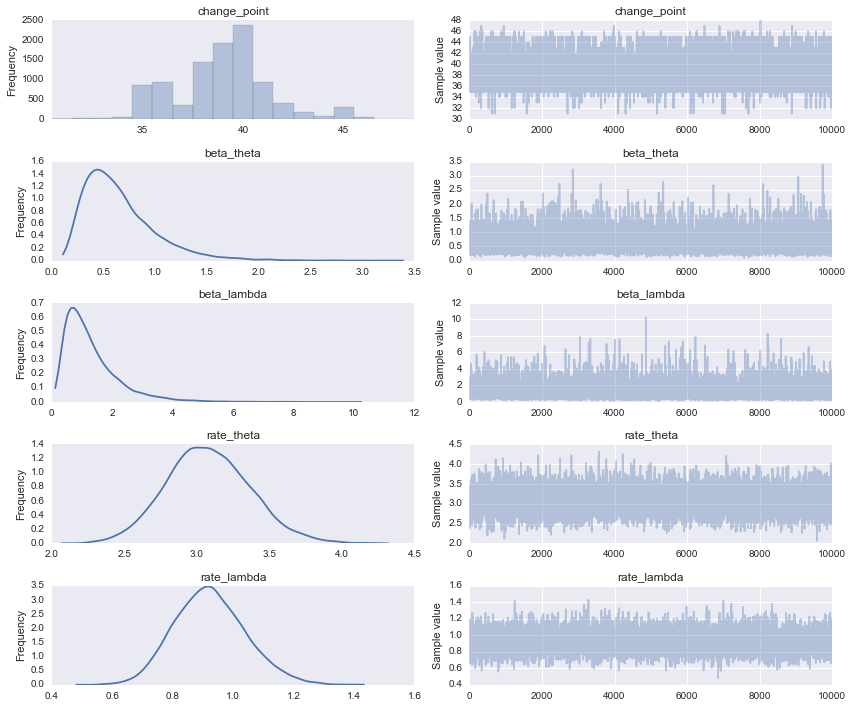

In [2]:
# Coal Mining Disaster Observations
Y = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
              2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 
              0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
              0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

# Specify Hierarchical Bayesian Model in PyMC
with pm.Model() as model:
    
    # Known values
    n = len(Y)
    alpha_theta = 0.5
    alpha_lambda = 0.5
    mu_theta = 0.5
    mu_lambda = 0.5
    nu_theta = 1.0
    nu_lambda = 1.0
    
    # Define hyperprior
    beta_theta = pm.InverseGamma('beta_theta', alpha = mu_theta, beta = nu_theta)
    beta_lambda = pm.InverseGamma('beta_lambda', alpha = mu_lambda, beta = nu_lambda)
    
    # Define prior:
    # Prior of pre- and post- change point accident rate
    rate_theta = pm.Gamma('rate_theta', alpha = alpha_theta, beta = beta_theta)
    rate_lambda = pm.Gamma('rate_lambda', alpha = alpha_lambda, beta = beta_lambda)
    
    # Prior for distribution of change_point location
    change_point = pm.DiscreteUniform('change_point', lower = 1, upper = n)
    
    # Allocate appropriate poisson rates to days before and after current change point location
    idx = np.arange(len(Y))
    rate = pm.switch(change_point >= idx, rate_theta, rate_lambda)
    
    # Data likelihood
    Y = pm.Poisson('Y', rate, observed = Y)
    
    # Markov Chain Monte Carlo sampling - Sampling Algorithms: https://github.com/pymc-devs/pymc3/tree/master/pymc3/step_methods
    # Initial value: Find starting value by optimization
    start = pm.find_MAP()
    
    # Using "NUTS" sampler for hyperprior
    step1 = pm.NUTS([beta_theta, beta_lambda])
    
    # Using "Metropolis-Hastings" for change point, since it accomodates discrete variables
    step2 = pm.Metropolis([change_point])
    
    # Using "NUTS" sampler for rate
    step3 = pm.NUTS([rate_theta, rate_lambda])
    
    # Samples: 1 Million samples take: ~ 25 minutes on MacBook Pro with 16 GB RAM
    trace = pm.sample(1000000, start = start, step = [step1, step2, step3], progressbar = True)

    
# Check the results
burn_in = 900000 # Posterior sample to discard
thin = 10 # Posterior sample to discard

# Plot Kernal Density Estimates and sampled values for each parameter
pm.traceplot(trace[burn_in::thin])

95% HDI - There is 95% chance that the parameter of interest lies in this interval

A Highest Density Interval (HDI) is a way of summarizing a distribution. The HDI of a posterior distribution indicates which points of this distribution are most credible. The width of the HDI is a way of measuring uncertainty in beliefs. HDI is the set of most probable values of a parameter $\theta$ that in total constitute $100 ∗ (1 − \alpha)$ % of the posterior mass. Mathematically HDI of a distribution is found as - For a given $\alpha$ we find the threshold $P^*$ on the pdf that satisfies:

$$1-\alpha = \int_{\theta:P(\theta|Y)> P^*}P(\theta|Y)d\theta$$

and then the HDI can be defined as:
$$C_{\alpha}(Y) = \{\theta : P(\theta|Y) P^*\}$$

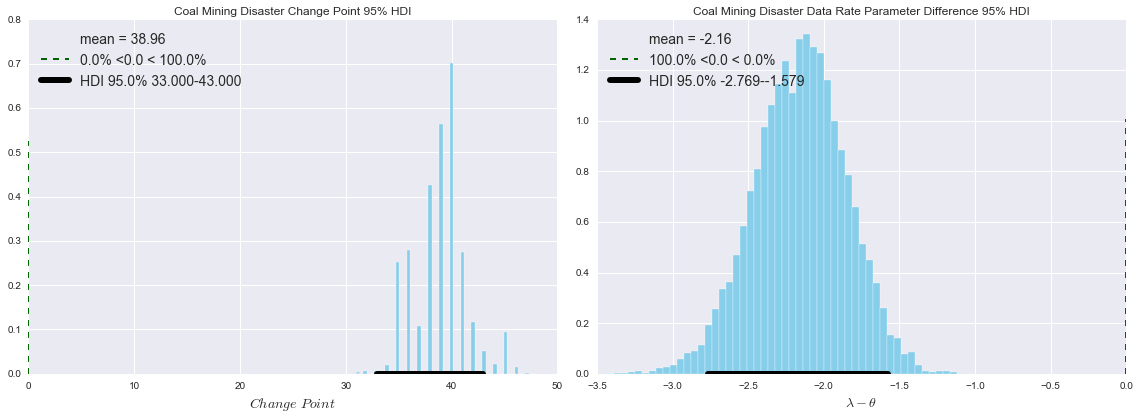

In [3]:
# 95% HDI
rate_theta_samples = trace['rate_theta'][burn_in::thin]
rate_lambda_samples = trace['rate_lambda'][burn_in::thin]
change_point_samples = trace['change_point'][burn_in::thin]

from plot_post import *

fig = plt.figure(figsize=(16, 6))

# Plot switchpoint
plt.subplot(1, 2, 1)
TITLE = 'Coal Mining Disaster Change Point 95% HDI'
plot_post(change_point_samples, xlab=r'$Change\ Point}$', title = TITLE,
          show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences among rate parameters
plt.subplot(1, 2, 2)
TITLE = 'Coal Mining Disaster Data Rate Parameter Difference 95% HDI'
plot_post((rate_lambda_samples - rate_theta_samples),  title = TITLE,
          xlab=r'$\lambda-\theta$', show_mode=False, comp_val=0, framealpha=0.5)

plt.tight_layout()
plt.show()

#### MCMC Sampling (I-710 Accident Data) 

In [4]:
# Read data from Excel file
xlsx = pd.ExcelFile('I-710-2005-all.xlsx')

df1 = pd.read_excel(xlsx, 'Freq-1')
df2 = pd.read_excel(xlsx, 'Freq-2')
df3 = pd.read_excel(xlsx, 'Freq-3')
df4 = pd.read_excel(xlsx, 'Freq-4')

In [5]:
# Observations: am, midday, pm, night
Y = np.array(df1['am'])

# Specify Hierarchical Bayesian Model in PyMC
with pm.Model() as model:
    
    # Known values
    n = len(Y)
    alpha_theta = 0.5
    alpha_lambda = 0.5
    mu_theta = 0.5
    mu_lambda = 0.5
    nu_theta = 1.0
    nu_lambda = 1.0
    
    # Define hyperprior
    beta_theta = pm.InverseGamma('beta_theta', alpha = mu_theta, beta = nu_theta)
    beta_lambda = pm.InverseGamma('beta_lambda', alpha = mu_lambda, beta = nu_lambda)
    
    # Define prior:
    # Prior of pre- and post- change point accident rate
    rate_theta = pm.Gamma('rate_theta', alpha = alpha_theta, beta = beta_theta)
    rate_lambda = pm.Gamma('rate_lambda', alpha = alpha_lambda, beta = beta_lambda)
    
    # Prior for distribution of change_point location
    change_point = pm.DiscreteUniform('change_point', lower = 1, upper = n)
    
    # Allocate appropriate poisson rates to days before and after current change point location
    idx = np.arange(len(Y))
    rate = pm.switch(change_point >= idx, rate_theta, rate_lambda)
    
    # Data likelihood
    Y = pm.Poisson('Y', rate, observed = Y)
    
    # Markov Chain Monte Carlo sampling - Sampling Algorithms: https://github.com/pymc-devs/pymc3/tree/master/pymc3/step_methods
    # Initial value: Find starting value by optimization
    start = pm.find_MAP()
    
    # Using "NUTS" sampler for hyperprior
    step1 = pm.NUTS([beta_theta, beta_lambda])
    
    # Using "Metropolis-Hastings" for change point, since it accomodates discrete variables
    step2 = pm.Metropolis([change_point])
    
    # Using "NUTS" sampler for rate
    step3 = pm.NUTS([rate_theta, rate_lambda])
    
    # Samples: 1 Million samples take: ~ 25 minutes on 2016 MacBook Pro with 16 GB RAM
    trace = pm.sample(1000000, start = start, step = [step1, step2, step3], progressbar = True)
    
    # Save the trace: 'wb' - write in binary format
    with open('s1_am.pkl', 'wb') as output_file:
        pickle.dump(trace, output_file)

Applied log-transform to beta_theta and added transformed beta_theta_log to model.
Applied log-transform to beta_lambda and added transformed beta_lambda_log to model.
Applied log-transform to rate_theta and added transformed rate_theta_log to model.
Applied log-transform to rate_lambda and added transformed rate_lambda_log to model.
 [-----------------100%-----------------] 1000000 of 1000000 complete in 1091.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ba8b410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13f463ed0>]], dtype=object)

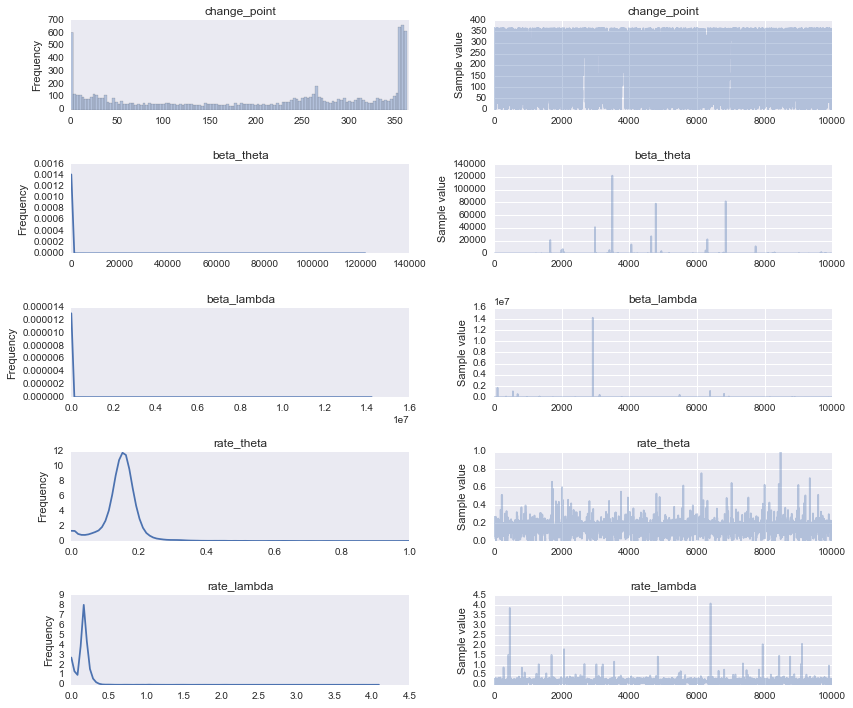

In [6]:
# Check the results
burn_in = 900000 # Posterior sample to discard
thin = 10 # Posterior sample to discard

# Plot Kernal Density Estimates and sampled values for each parameter
pm.traceplot(trace[burn_in::thin])

In [7]:
# Load trace
#trace = pickle.load(open("s1p4.pkl", 'rb'))
#print trace.varnames
rate_theta_samples = trace['rate_theta'][burn_in::thin]
rate_lambda_samples = trace['rate_lambda'][burn_in::thin]
change_point_samples = trace['change_point'][burn_in::thin]

# Mode of Change Point samples
m = stats.mode(change_point_samples)
print m

ModeResult(mode=array([356]), count=array([319]))


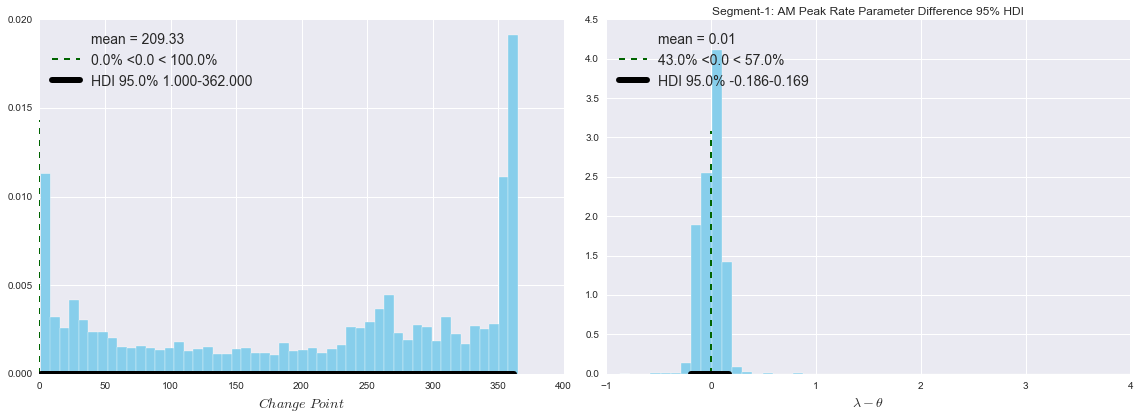

In [8]:
# Plotting 95% HDI
from plot_post import *

fig = plt.figure(figsize=(16, 6))

# Plot switchpoint
plt.subplot(1, 2, 1)
plot_post(change_point_samples, xlab=r'$Change\ Point}$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences among rate parameters
plt.subplot(1, 2, 2)
TITLE = 'Segment-1: AM Peak Rate Parameter Difference 95% HDI'
plot_post((rate_lambda_samples - rate_theta_samples),  title = TITLE,
          xlab=r'$\lambda-\theta$', show_mode=False, comp_val=0, framealpha=0.5)


plt.tight_layout()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1406013d0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x135dae350>]], dtype=object)

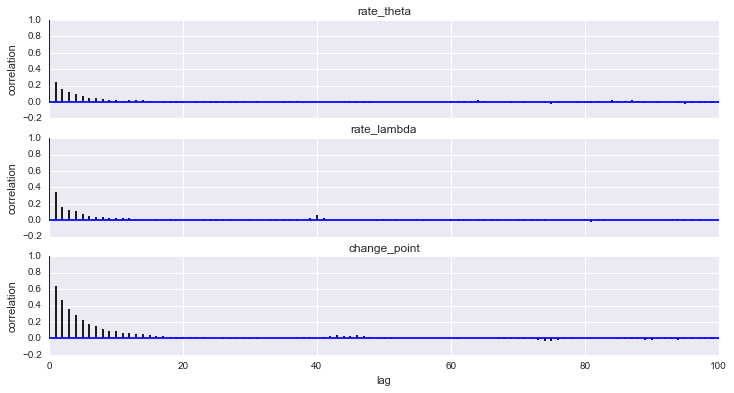

In [9]:
# Plot Autocorrelation
pm.autocorrplot(trace[burn_in::thin], varnames=[rate_theta, rate_lambda, change_point])

In [10]:
# How often rate_theta < rate_lambda?
print (rate_theta_samples < rate_lambda_samples).sum()
print (rate_theta_samples < rate_lambda_samples).mean()

5740
0.574


In [11]:
#help(pm.plot_posterior)
#pm.plot_posterior((rate_lambda_samples - rate_theta_samples))

#### Reference
1. Carlin, B.P., A.E. Gelfand, A.F.M. Smith (1992). *Hierarchical Bayesian Analysis of Changepoint Problems.* Applied Statistics, Vol. 14, No. 2, pp. 389-405

2. Raftery, A. and Akman, V. (1986). *Bayesian analysis of a Poisson process with a change-point.* Biometrika, 73(1), 85-89

3. Jarrett, R.G. (1979). “A note on the intervals between coal-mining disasters.” Biometrika, 66(1), 191-193.

4. Kruschke, J.K., Doing Bayesian Data Analysis: A Tutorial with R and Bugs. Academic Press. 2010.

5. Murphy, K.P., Machine Learning: A Probabilistic Perspective. The MIT Press, 2012.

6. Gelman, A., Carlin, J.B., Stern, H.S., Dunson, D.B., Vehtari, A., Rubin, D.B. Bayesian Data Analysis. CRC Press, 2013.